In [1]:
%pip install ipywidgets

## MP 573 Lecture 6: Fourier Transform in N Dimensions
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Recap of the Fourier transform

As we have covered in our lecture notes, here is the expression for the Fourier transform in 2D:

$$\hat{f}(u,v) = \int{ \int{ f(x,y) e^{-i 2 \pi (x u + y v)} dx dy}}$$

And here is the expression for the inverse Fourier transform:

$$ f(x,y) = \int{ \int{ \hat{f}(u,v) e^{i 2 \pi (x u + y v)} du dv}}$$

Note that the inverse Fourier transform has a pretty intuitive interpretation, ie: expressing our image $f(x,y)$ as a superposition (sum) of complex exponentials $e^{i 2 \pi (x u + y v)}$ (each with spatial frequencies $u$ and $v$ along the $x$ and $y$ dimensions, respectively). Each of these complex exponentials is weighted in the superposition by a certain complex-valued weight $\hat{f}(u,v)$ (ie: the value of the Fourier transform of $f$ at the corresponding frequency). 



# Create a synthetic image

Now, let us create a synthetic image... Note that even though our derivations have been for continuous-domain functions, in practice all our implementations will occur with discrete-domain signals (ie: finite N-dimensional arrays). This gap will be bridged later in the course when we study sampling and Discrete Fourier Transforms. 

In [2]:
## Let's create some signal
# Blank image
n = 401
p = np.zeros ((n, n))
FOV = 40

# Create the pixel grid and simple image
y, x = np.mgrid[-40/2:40/2:(1j*n), -40/2:40/2:(1j*n)]
f = np.less(np.abs(x*x*0.03) + np.abs(y*y*0.3),1)*np.exp(1j*0.001)

# Create the corresponding frequency grid
du = 2/FOV
u = du*np.linspace(1,n,n)
u = u - np.mean(u)

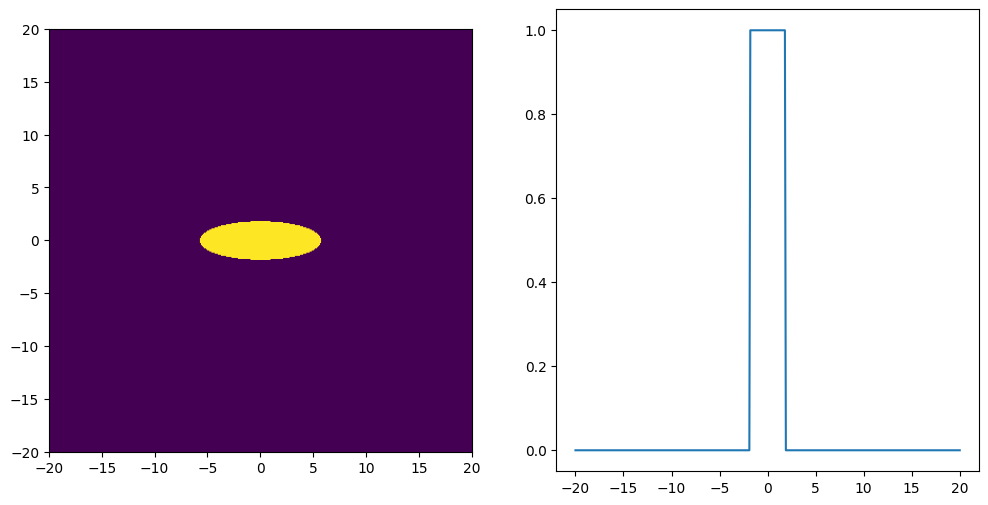

In [3]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
imgplot = plt.imshow(abs(f), extent = [-FOV/2, FOV/2, -FOV/2, FOV/2])

plt.subplot(1,2,2)
imgplot = plt.plot(y[:,201], abs(f[:,201]))

                                   

# Run the Fourier transform

Now that we have an image, we can take its (discrete) Fourier transform. If you are curious about the meaning of the fftshift/ifftshift commands, we will cover this when we study the discrete Fourier transform and the fast Fourier transform. For now, let us simply assume that this following line returns the Fourier transform of our image. 

In [4]:
fhat = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(f)))

# Show the magnitude of the Fourier transform

The Fourier transform of a signal (even a real-valued signal) is generally complex-valued. This means that we can calculate its magnitude and display it as shown below. 

*Why do you think we show the logarithm of the magnitude, rather than showing directly the magnitude?*

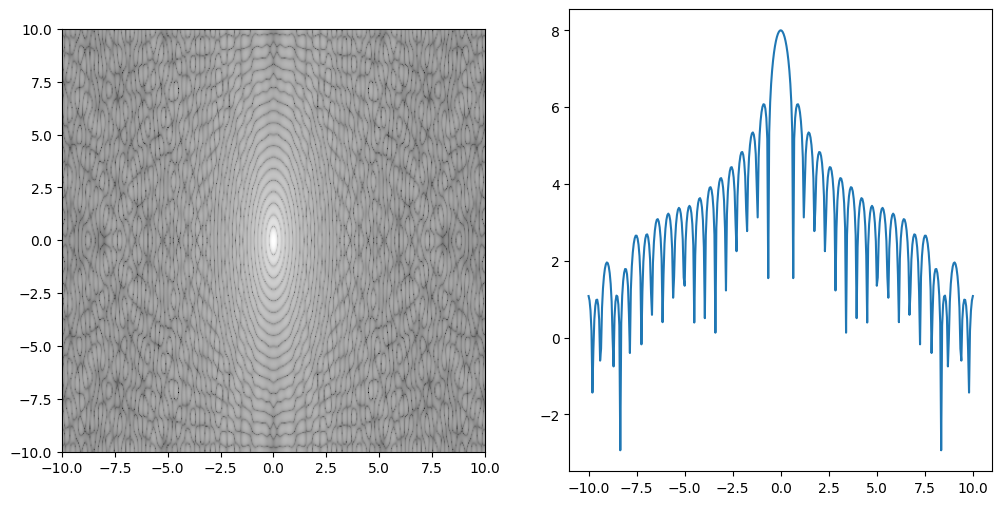

In [5]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
imgplot = plt.imshow(np.log(abs(fhat)),extent = [u[0], u[n-1], u[0], u[n-1]],cmap='gray')
plt.subplot(1,2,2)
imgplot = plt.plot(u, np.log(abs(fhat[:,201])))

# Show the phase of the Fourier transform

Just like we can display the magnitude of the Fourier transform, we can display its phase (see below). 

Note that we could also show the real and imaginary values of the Fourier transform, although this is probably not as common. 

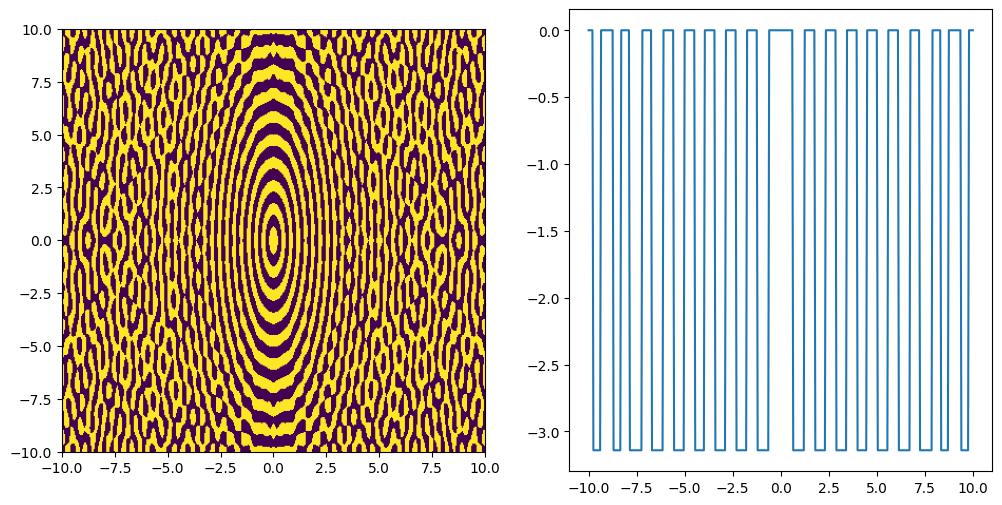

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
imgplot = plt.imshow(np.angle(fhat),extent = [u[0], u[n-1], u[0], u[n-1]])
plt.subplot(1,2,2)
imgplot = plt.plot(u, np.angle(fhat[:,201]))

# Load some Fourier transform imaging data (MRI) and reconstruct the corresponding image

In the next few cells, we will run a similar exercise but using data based on Magnetic Resonance Imaging of the brain. Specifically, we will load a file with Fourier domain data, reconstruct the image by running an inverse Fourier transform, and display the magnitude and phase of the reconstructed image. 

In [7]:
# If data are not here, copy over
import os.path
check_file = os.path.isfile('data/brain_fourier.mat')
if check_file == False:
  !wget https://github.com/dherarr/mp573_2025/blob/main/data/brain_fourier.mat?raw=true
  !mkdir data
  !mv brain_fourier.mat\?raw\=true data/brain_fourier.mat

# Load some image from file
#import h5py
#hdf5_path = 'dataset.hdf5'
#brain_dataset = h5py.File(hdf5_path, "r")
from os.path import dirname, join as pjoin
import scipy.io as sio
data_dir = pjoin('.', 'data')
mat_fname = pjoin(data_dir, 'brain_fourier.mat')
mat_contents = sio.loadmat(mat_fname)
fhat = mat_contents['dataLR']

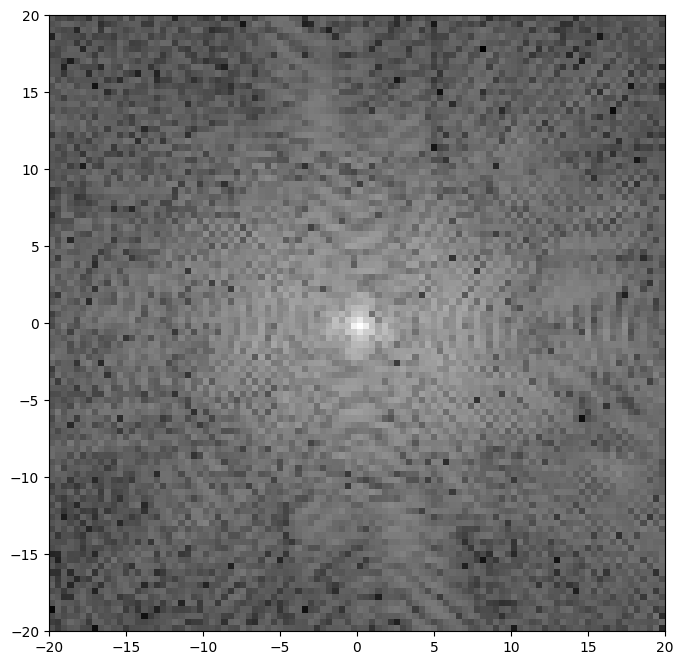

In [8]:
plt.figure(figsize=(8,8))
imgplot = plt.imshow(np.log(abs(fhat)), extent = [-FOV/2, FOV/2, -FOV/2, FOV/2],cmap='gray')

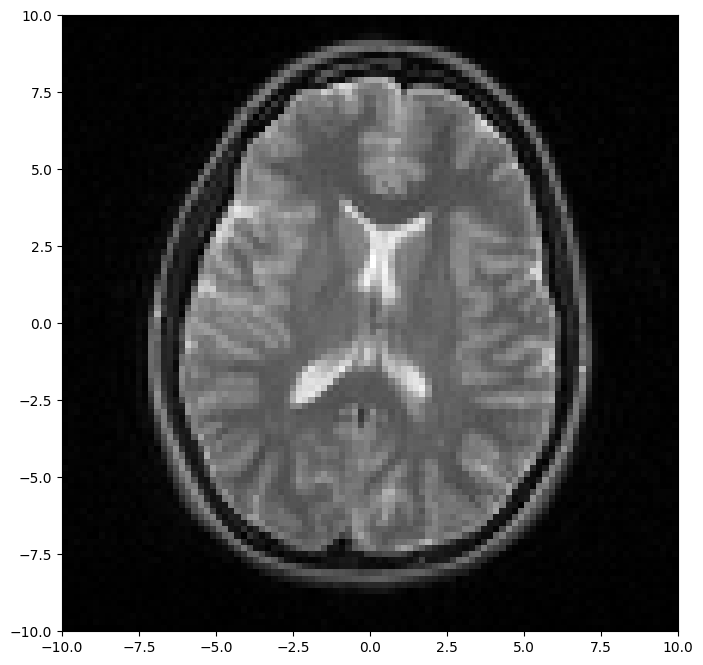

In [9]:
f = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fhat)))
plt.figure(figsize=(8,8))
imgplot = plt.imshow(abs(f),extent = [u[0], u[n-1], u[0], u[n-1]],cmap='gray')

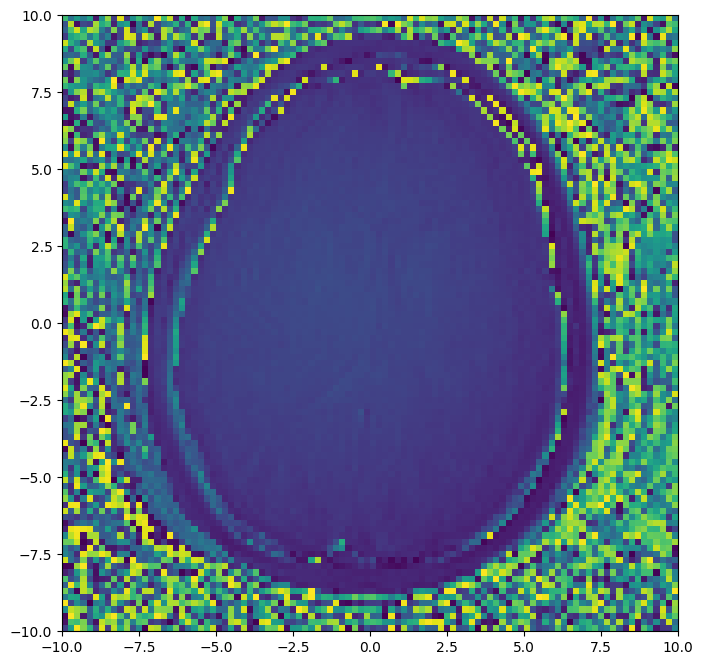

In [10]:
plt.figure(figsize=(8,8))
imgplot = plt.imshow(np.angle(f),extent = [u[0], u[n-1], u[0], u[n-1]])

# Noise and artifacts

Finally, we will add some noise or artifact to the Fourier data, and see what happens to the corresponding image. Note that in the next cell you can manipulate the type and level of artifact that is included in the Fourier data, and then visualize the effect on the reconstructed image.

In [11]:
# Now add some noise or artifact to the data
#fhat2 = fhat.copy(); fhat2[55,53] = fhat2[65,62] + 40 # Uncomment this line for spike in Fourier-space
fhat2 = 0*fhat; fhat2[10:90,30:70] = fhat[10:90,30:70] # Uncomment this to keep only the low frequencies

#The next few lines add some Gaussian noise (comment last line if unwanted)
sizex = len(fhat2)
sizey = len(fhat2[:])
std = 0.5
noise = np.random.normal(0,std,[sizex,sizey]) + np.random.normal(0,std,[sizex,sizey])*1j
#fhat2 = fhat.copy(); fhat2 = fhat2 + noise

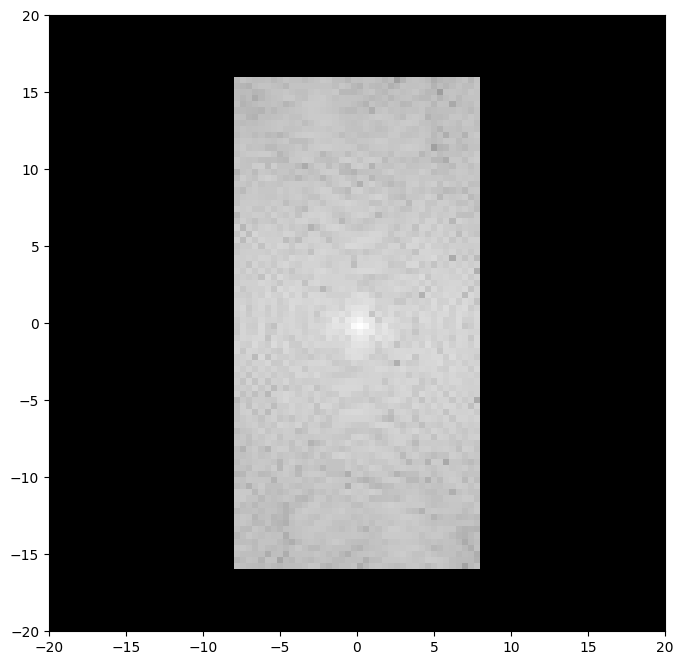

In [12]:
plt.figure(figsize=(8,8))
imgplot = plt.imshow(np.log(abs(fhat2 + 0.000000001)), extent = [-FOV/2, FOV/2, -FOV/2, FOV/2],cmap='gray')

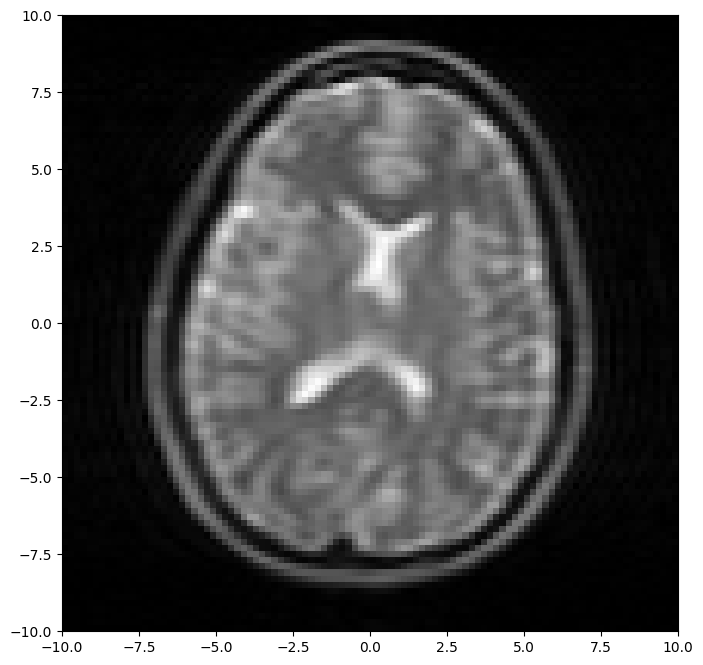

In [13]:
f2 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fhat2)))
plt.figure(figsize=(8,8))
imgplot = plt.imshow(abs(f2),extent = [u[0], u[n-1], u[0], u[n-1]],cmap='gray')